# Delta Convergence via Variational Bottleneck
This notebook demonstrates how predictive coding with a variational bottleneck leads to delta-like convergence of structured representations.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(0)
np.random.seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
# Synthetic data generation
N, d, D = 1000, 2, 20
W_true = np.random.randn(D, d)
b_true = np.random.randn(D)
Phi_data = np.random.randn(N, d)
Psi_data = Phi_data @ W_true.T + b_true + 0.1 * np.random.randn(N, D)

Phi_tensor = torch.tensor(Phi_data, dtype=torch.float32).to(device)
Psi_tensor = torch.tensor(Psi_data, dtype=torch.float32).to(device)


In [3]:
# Encoder and decoder definitions
class Encoder(nn.Module):
    def __init__(self, d, k):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, 64), nn.ReLU(), nn.Linear(64, k)
        )
    def forward(self, x): return self.net(x)

class Decoder(nn.Module):
    def __init__(self, k, D):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(k, 64), nn.ReLU(), nn.Linear(64, D)
        )
    def forward(self, z): return self.net(z)

k = 5
encoder = Encoder(d, k).to(device)
decoder = Decoder(k, D).to(device)
optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)


In [4]:
# Loss function with variational bottleneck
def loss_fn(Psi, Phi, encoder, decoder, lambda_kl=1.0):
    z = encoder(Phi)
    recon = decoder(z)
    recon_loss = nn.functional.mse_loss(recon, Psi)
    kl_loss = 0.5 * torch.mean(torch.sum(z ** 2, dim=1))  # Assumes standard normal prior
    return recon_loss + lambda_kl * kl_loss, recon_loss.item(), kl_loss.item()


In [5]:
# Training loop
losses, recon_losses, kl_losses = [], [], []
for epoch in range(500):
    optimizer.zero_grad()
    loss, recon, kl = loss_fn(Psi_tensor, Phi_tensor, encoder, decoder)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    recon_losses.append(recon)
    kl_losses.append(kl)


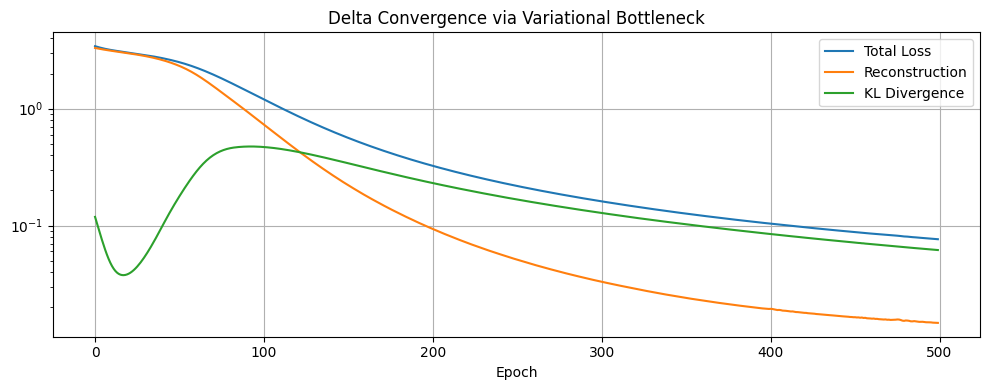

In [6]:
# Plot total and decomposed loss
plt.figure(figsize=(10, 4))
plt.plot(losses, label='Total Loss')
plt.plot(recon_losses, label='Reconstruction')
plt.plot(kl_losses, label='KL Divergence')
plt.yscale("log")
plt.xlabel("Epoch")
plt.title("Delta Convergence via Variational Bottleneck")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


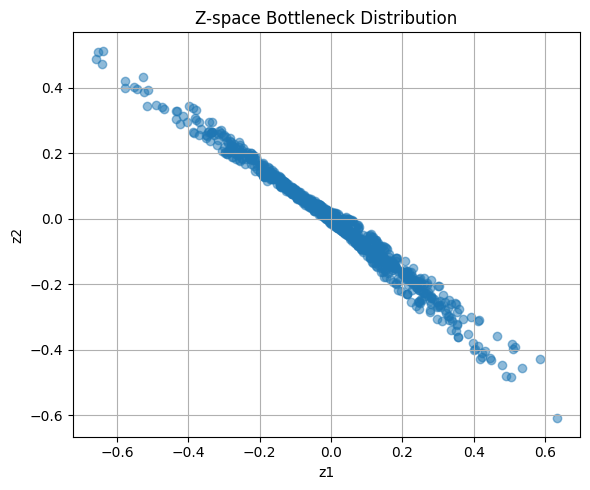

In [7]:
# Latent Z collapse visualization
z_latent = encoder(Phi_tensor).detach().cpu().numpy()
plt.figure(figsize=(6, 5))
plt.scatter(z_latent[:, 0], z_latent[:, 1], alpha=0.5)
plt.title("Z-space Bottleneck Distribution")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(True)
plt.tight_layout()
plt.show()
